In [2]:
import numpy
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from typing import Tuple, List

In [3]:
df = pd.read_csv("./data/household_power_consumption_daily.csv", parse_dates=True, index_col=0)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934
2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800


In [4]:
def split_data(data: numpy) -> Tuple[numpy.array, numpy.array]:
    train, test = data[1: -328], data[-328:-6]
    train = numpy.array(numpy.split(train, len(train)/7))
    test = numpy.array(numpy.split(test, len(test)/7))
    return train, test

In [5]:
train, test = split_data(df.values)

In [6]:
def reshape_nn_input(x: numpy, n_input: int, n_output):
    data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    X, y = list(), list()
    first_index = 0
    for _ in range(len(data)):
        in_len = first_index + n_input
        target_len = in_len + n_output
        if target_len <= len(data):
            X.append(data[first_index:in_len, :])
            y.append(data[in_len:target_len, 0])
        first_index += 1
    return numpy.array(X), numpy.array(y)

In [7]:
x_train, y_train = reshape_nn_input(x=train, n_input=14, n_output=7)
x_train.shape, y_train.shape

((1093, 14, 8), (1093, 7))

In [69]:
def conv_model(x: numpy, y: numpy):
    timestamps, features, num_outputs = x.shape[1], x.shape[2], y.shape[1]
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(32, 3, activation='relu', input_shape=(timestamps, features)))
    model.add(keras.layers.Conv1D(32, 3, activation='relu'))
    model.add(keras.layers.MaxPooling1D())
    model.add(keras.layers.Conv1D(16, 3, activation='relu'))
    model.add(keras.layers.MaxPooling1D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation=keras.activations.relu))
    model.add(keras.layers.Dense(num_outputs))

    model.compile(
        loss=keras.losses.mean_absolute_error,
        optimizer=keras.optimizers.Adam()
    )
    history = model.fit(x, y, epochs=70, batch_size=32, verbose=2)
    return history, model

In [70]:
history, model = conv_model(x_train, y_train)

Epoch 1/70
35/35 - 1s - loss: 4173.9229 - 780ms/epoch - 22ms/step
Epoch 2/70
35/35 - 0s - loss: 519.0687 - 94ms/epoch - 3ms/step
Epoch 3/70
35/35 - 0s - loss: 440.5217 - 90ms/epoch - 3ms/step
Epoch 4/70
35/35 - 0s - loss: 418.0145 - 92ms/epoch - 3ms/step
Epoch 5/70
35/35 - 0s - loss: 398.2742 - 89ms/epoch - 3ms/step
Epoch 6/70
35/35 - 0s - loss: 390.9323 - 83ms/epoch - 2ms/step
Epoch 7/70
35/35 - 0s - loss: 398.2495 - 87ms/epoch - 2ms/step
Epoch 8/70
35/35 - 0s - loss: 384.6633 - 106ms/epoch - 3ms/step
Epoch 9/70
35/35 - 0s - loss: 394.9676 - 86ms/epoch - 2ms/step
Epoch 10/70
35/35 - 0s - loss: 386.1475 - 85ms/epoch - 2ms/step
Epoch 11/70
35/35 - 0s - loss: 392.4054 - 85ms/epoch - 2ms/step
Epoch 12/70
35/35 - 0s - loss: 378.9425 - 89ms/epoch - 3ms/step
Epoch 13/70
35/35 - 0s - loss: 391.6038 - 82ms/epoch - 2ms/step
Epoch 14/70
35/35 - 0s - loss: 382.2378 - 76ms/epoch - 2ms/step
Epoch 15/70
35/35 - 0s - loss: 373.9608 - 81ms/epoch - 2ms/step
Epoch 16/70
35/35 - 0s - loss: 392.4336 - 77m

In [71]:
def model_prediction(model, x: numpy, n_inputs=7):
    # data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    # print(data.shape)

    last_week = x[-2:][:,:]
    print(last_week.shape)
    last_week = last_week.reshape((1, last_week.shape[0] * last_week.shape[1], last_week.shape[-1]))

    yhat = model.predict(last_week, verbose=1)

    return yhat

In [72]:
train[-2:][:,:].shape

(2, 7, 8)

In [73]:
yhat = model_prediction(model=model, x=train)

(2, 7, 8)
1/1 [==============================] - 0s 108ms/step


In [74]:
yhat

array([[1829.6663, 1684.7067, 1790.8286, 1759.2418, 1770.0956, 1633.162 ,
        1811.9761]], dtype=float32)

In [75]:
def flatten_shape(array: numpy):
    array_multiplication = array.shape[0] * array.shape[1]
    return numpy.reshape(array, (array_multiplication,))

In [76]:
yhat_values = flatten_shape(yhat)

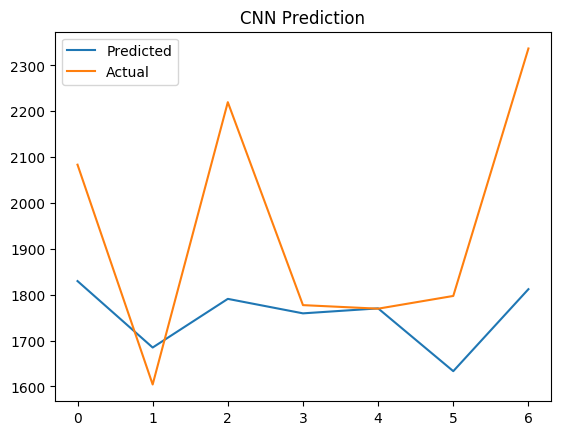

In [77]:
plt.figure()
plt.plot(yhat_values, label="Predicted")
plt.plot(test[0][:,0], label="Actual")
plt.title("CNN Prediction")
plt.legend()
plt.show()

In [78]:
def rmse_evaluation(actual: numpy, predicted: numpy):
    scores = list()

    for i in range(actual.shape[1]):
        rmse = numpy.sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = numpy.sqrt(s/(actual.shape[0] * actual.shape[1]))
    return score, scores

def evaluate_model(model, train, test):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model_prediction(model=model, x=history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
    predictions = predictions.reshape((46,7))
    # return predictions
    score, scores = rmse_evaluation(test[:,:,0], predictions)
    return score, scores

def sunnarize_scores(name, score, scores):
    n_scores = ", ".join(["%.1f"%s for s in scores ])
    print("%s: {%.3f} %s" % (name, score, n_scores))

def model_prediction(model, x: numpy, n_inputs=7):
    data = numpy.array(x)
    # data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

    last_week = data[-2:][:,:]
    last_week = last_week.reshape((1, last_week.shape[0] * last_week.shape[1], last_week.shape[-1]))
    # last_week = last_week.reshape((1, len(last_week), 8))

    yhat = model.predict(last_week, verbose=0)

    return yhat

CNN: {381.251} 378.1, 383.3, 351.0, 401.4, 345.8, 317.9, 471.9


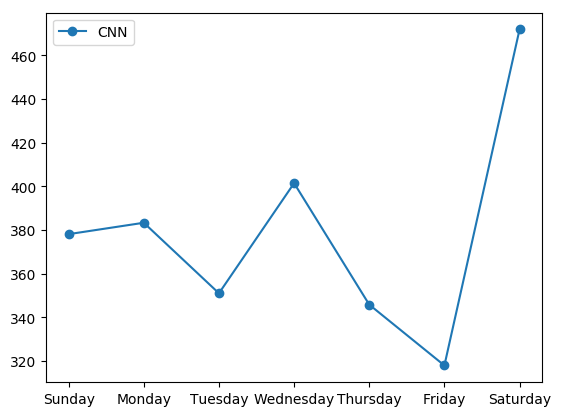

In [79]:
days = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
score, scores = evaluate_model(model=model, train=train, test=test)
sunnarize_scores("CNN", score,scores)

plt.plot(days, scores, marker='o', label="CNN")
plt.legend()
plt.show()